# Filter viral barcodes in transcripts
This notebook filters viral barcodes in 10X transcriptome data to remove UMIs that are likely derived from leaked transcripts.

## Notebook setup
Import python modules:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import pandas as pd

import plotnine as p9

import scipy

import statsmodels.stats.multitest

Get `snakemake` variables [as described here](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#jupyter-notebook-integration):

In [2]:
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial3_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_by_cell_corrected_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_by_cell_corrected.csv.gz'
expt = 'scProgenyProduction_trial3'
viral_bc_by_cell_filtered_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_by_cell_filtered.csv.gz'
plot = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_by_cell_filtered.pdf'
barcoded_viral_genes = ['fluHA', 'fluNA']
fdr = 0.0001

## Organize data

Read the viral barcode UMI counts data into a pandas dataframe:

In [3]:
viral_bc_counts = pd.read_csv(viral_bc_by_cell_corrected_csv)
viral_bc_counts = (viral_bc_counts
                   .rename(columns={'count': 'viral_bc_UMIs'}))
assert set(viral_bc_counts['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
display(viral_bc_counts)

,cell_barcode,gene,viral_barcode,viral_bc_UMIs
0,AAACGAAGTAGACGTG,fluHA,AAGTAAGCGACATGAG,18
1,AAACGAAGTAGACGTG,fluHA,CAGTCAGCGACATGAG,1
2,AAACGAATCAGTGGGA,fluHA,TGCAACTTACGCAGAG,1
3,AAAGGATTCTGATGGT,fluHA,GTGGAGTCGCCAGTTC,10
4,AAAGGGCCAGGCTACC,fluHA,AAAGTGATCCCCATAC,1
...,...,...,...,...
2110,TTTCACAAGCCAAGCA,fluNA,GGTATCAGGTATGTTT,1
2111,TTTCACAAGCCAAGCA,fluNA,GGTATCAGTTATTGTT,23
2112,TTTCAGTAGGAGACCT,fluNA,TGGGAGGAAAGAGGTA,1
2113,TTTCGATTCAATCCAG,fluNA,CGATTTCAGAACTTAA,1


Read the total number of UMIs per cell into a pandas dataframe. Only keep relevant columns.

In [4]:
all_cells = pd.read_csv(viral_tag_by_cell_csv)
all_cells = all_cells[['cell_barcode',
                       'infected',
                       'infecting_viral_tag',
                       'total_UMIs',
                       'viral_UMIs',
                       'cellular_UMIs',
                       'frac_viral_UMIs']]
display(all_cells)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs
0,AAACCCAGTAACAAGT,False,none,5699,0,5699,0.000000
1,AAACCCATCATTGCTT,False,none,10530,0,10530,0.000000
2,AAACGAAAGATGTTGA,False,none,13065,0,13065,0.000000
3,AAACGAAGTACTTCCC,True,wt,6629,3017,3612,0.455121
4,AAACGAAGTAGACGTG,True,wt,14162,517,13645,0.036506
...,...,...,...,...,...,...,...
3360,TTTGATCTCCCGTTCA,False,none,7229,0,7229,0.000000
3361,TTTGATCTCGCATTGA,True,wt,19350,1226,18124,0.063359
3362,TTTGGAGAGTTGCCTA,False,none,7498,0,7498,0.000000
3363,TTTGGAGGTATCGTTG,True,wt,17202,423,16779,0.024590


Sanity check that `total_UMIs` is equal to `viral_UMIs + cellular_UMIs`:

In [5]:
assert bool((all_cells['total_UMIs'] ==
             all_cells['viral_UMIs'] +
             all_cells['cellular_UMIs'])
            .all()), "UMI counts do not add up"

Merge dataframes:

In [6]:
viral_bc_frac = pd.merge(
    left=pd.concat([all_cells.assign(gene=gene)
                    for gene in barcoded_viral_genes]),
    right=viral_bc_counts,
    how='outer',
    on=['cell_barcode', 'gene'],
    validate='one_to_many')
assert (viral_bc_frac['cell_barcode'].unique() ==
        all_cells['cell_barcode'].unique()).all(), \
       "Cell barcodes in merged dataframe don't " \
       "match barcodes in source data."
assert (viral_bc_frac['viral_barcode'].nunique() ==
        viral_bc_counts['viral_barcode'].nunique()), \
       "Number of viral barcodes in merged dataframe don't " \
       "match number of barcodes in source data."

# Make `infecting_viral_tag` column ordered category
viral_bc_frac['infecting_viral_tag'] = (viral_bc_frac['infecting_viral_tag']
                                        .astype('category')
                                        .cat
                                        .reorder_categories(['none',
                                                             'wt',
                                                             'syn',
                                                             'both']))

display(viral_bc_frac)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs
0,AAACCCAGTAACAAGT,False,none,5699,0,5699,0.000000,fluHA,NaN,NaN
1,AAACCCATCATTGCTT,False,none,10530,0,10530,0.000000,fluHA,NaN,NaN
2,AAACGAAAGATGTTGA,False,none,13065,0,13065,0.000000,fluHA,NaN,NaN
3,AAACGAAGTACTTCCC,True,wt,6629,3017,3612,0.455121,fluHA,NaN,NaN
4,AAACGAAGTAGACGTG,True,wt,14162,517,13645,0.036506,fluHA,AAGTAAGCGACATGAG,18.0
...,...,...,...,...,...,...,...,...,...,...
7706,TTTGATCTCCCGTTCA,False,none,7229,0,7229,0.000000,fluNA,NaN,NaN
7707,TTTGATCTCGCATTGA,True,wt,19350,1226,18124,0.063359,fluNA,NaN,NaN
7708,TTTGGAGAGTTGCCTA,False,none,7498,0,7498,0.000000,fluNA,NaN,NaN
7709,TTTGGAGGTATCGTTG,True,wt,17202,423,16779,0.024590,fluNA,ACATCTTATTTACACG,6.0


Calculate **each barcode's** fraction of all UMIs per cell:

In [7]:
viral_bc_frac = (
    viral_bc_frac
    .assign(viral_bc_UMIs=lambda x: (x['viral_bc_UMIs']
                                     .fillna(0)
                                     .astype(int, errors='raise'))))


viral_bc_frac['frac_viral_bc_UMIs'] = (
    viral_bc_frac['viral_bc_UMIs'] /
    viral_bc_frac['total_UMIs'])

display(viral_bc_frac)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs
0,AAACCCAGTAACAAGT,False,none,5699,0,5699,0.000000,fluHA,NaN,0,0.000000
1,AAACCCATCATTGCTT,False,none,10530,0,10530,0.000000,fluHA,NaN,0,0.000000
2,AAACGAAAGATGTTGA,False,none,13065,0,13065,0.000000,fluHA,NaN,0,0.000000
3,AAACGAAGTACTTCCC,True,wt,6629,3017,3612,0.455121,fluHA,NaN,0,0.000000
4,AAACGAAGTAGACGTG,True,wt,14162,517,13645,0.036506,fluHA,AAGTAAGCGACATGAG,18,0.001271
...,...,...,...,...,...,...,...,...,...,...,...
7706,TTTGATCTCCCGTTCA,False,none,7229,0,7229,0.000000,fluNA,NaN,0,0.000000
7707,TTTGATCTCGCATTGA,True,wt,19350,1226,18124,0.063359,fluNA,NaN,0,0.000000
7708,TTTGGAGAGTTGCCTA,False,none,7498,0,7498,0.000000,fluNA,NaN,0,0.000000
7709,TTTGGAGGTATCGTTG,True,wt,17202,423,16779,0.024590,fluNA,ACATCTTATTTACACG,6,0.000349


**For each cell, for each gene,** sum the number of viral barcode UMIs.

In [8]:
viral_bc_frac = (
    viral_bc_frac
    .assign(sum_UMIs_with_viral_bc_for_cell_and_gene=(
        lambda x: ((x
                    .groupby(['cell_barcode', 'gene'])
                    ['viral_bc_UMIs'])
                   .transform('sum')))))

display(viral_bc_frac)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,sum_UMIs_with_viral_bc_for_cell_and_gene
0,AAACCCAGTAACAAGT,False,none,5699,0,5699,0.000000,fluHA,NaN,0,0.000000,0
1,AAACCCATCATTGCTT,False,none,10530,0,10530,0.000000,fluHA,NaN,0,0.000000,0
2,AAACGAAAGATGTTGA,False,none,13065,0,13065,0.000000,fluHA,NaN,0,0.000000,0
3,AAACGAAGTACTTCCC,True,wt,6629,3017,3612,0.455121,fluHA,NaN,0,0.000000,0
4,AAACGAAGTAGACGTG,True,wt,14162,517,13645,0.036506,fluHA,AAGTAAGCGACATGAG,18,0.001271,19
...,...,...,...,...,...,...,...,...,...,...,...,...
7706,TTTGATCTCCCGTTCA,False,none,7229,0,7229,0.000000,fluNA,NaN,0,0.000000,0
7707,TTTGATCTCGCATTGA,True,wt,19350,1226,18124,0.063359,fluNA,NaN,0,0.000000,0
7708,TTTGGAGAGTTGCCTA,False,none,7498,0,7498,0.000000,fluNA,NaN,0,0.000000,0
7709,TTTGGAGGTATCGTTG,True,wt,17202,423,16779,0.024590,fluNA,ACATCTTATTTACACG,6,0.000349,6


## Plots
Set base plot style:

In [9]:
p9.theme_set(p9.theme_classic())

### Per cell metrics
Summary figures that address number and fraction of barcoded viral UMIs **in aggregate for each cell and gene**.

Plot number of UMIs that contain a viral barcode per cell-gene combination and fraction of UMIs that contain a viral barcode per cell-gene combination.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 25 rows containing missing values.


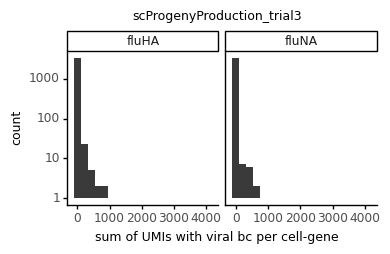

<ggplot: (8791849432799)>

In [10]:
fig = (p9.ggplot((viral_bc_frac
                  .drop_duplicates(subset=['cell_barcode', 'gene'])),
                 p9.aes(x='sum_UMIs_with_viral_bc_for_cell_and_gene')) +
       p9.geom_histogram(bins=20, fill="#3a3a3a") +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.labs(x='sum of UMIs with viral bc per cell-gene',) +
       p9.scale_y_log10() +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

### Per barcode metrics
Figures that show the outcomes **for each barcode individually.**

Plot distribution of each barcode's fraction of a cell's total UMIs.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 77 rows containing missing values.


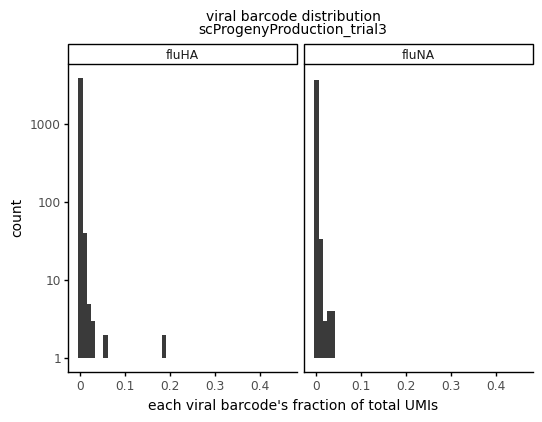

<ggplot: (8792524036232)>

In [11]:
fig = (p9.ggplot(viral_bc_frac, p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=50, fill="#3a3a3a") +
       p9.facet_grid('~gene') +
       p9.ggtitle('viral barcode distribution\n'
                  f'{expt}') +
       p9.labs(x='each viral barcode\'s fraction of total UMIs',) +
       p9.scale_y_log10() +
       p9.theme(figure_size=(6, 4),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

# Filtering
Now, I add a column to keep track of whether a barcode is retained or filtered out. If it is filtered out, I add the reason to list in the "reason" column."

In [12]:
viral_bc_frac['filtered'] = False
viral_bc_frac['reason'] = [[] for i in range(viral_bc_frac.shape[0])]

viral_bc_frac

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,sum_UMIs_with_viral_bc_for_cell_and_gene,filtered,reason
0,AAACCCAGTAACAAGT,False,none,5699,0,5699,0.000000,fluHA,NaN,0,0.000000,0,False,[]
1,AAACCCATCATTGCTT,False,none,10530,0,10530,0.000000,fluHA,NaN,0,0.000000,0,False,[]
2,AAACGAAAGATGTTGA,False,none,13065,0,13065,0.000000,fluHA,NaN,0,0.000000,0,False,[]
3,AAACGAAGTACTTCCC,True,wt,6629,3017,3612,0.455121,fluHA,NaN,0,0.000000,0,False,[]
4,AAACGAAGTAGACGTG,True,wt,14162,517,13645,0.036506,fluHA,AAGTAAGCGACATGAG,18,0.001271,19,False,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7706,TTTGATCTCCCGTTCA,False,none,7229,0,7229,0.000000,fluNA,NaN,0,0.000000,0,False,[]
7707,TTTGATCTCGCATTGA,True,wt,19350,1226,18124,0.063359,fluNA,NaN,0,0.000000,0,False,[]
7708,TTTGGAGAGTTGCCTA,False,none,7498,0,7498,0.000000,fluNA,NaN,0,0.000000,0,False,[]
7709,TTTGGAGGTATCGTTG,True,wt,17202,423,16779,0.024590,fluNA,ACATCTTATTTACACG,6,0.000349,6,False,[]


I will also write a function that manages the value of the filtered column. If the barcode is already filtered, this function will return true. If the barcode is not already filtered, it will be subject to whatever test the filtering step requires.

For example, if a viral barcode is filtered because it is not above background frequency (`filtered = True`), but the barcode is only found in one cell, the `filtered` flag should still remain `True`.

In [13]:
def check_filter(filtered_value, step_value):
    if filtered_value is True:
        return True
    else:
        return step_value

## Viral barcode frequency above background
### Statistical Tests
I want to perform a statistical test for each barcode to see if I can reject the null hypothesis that it fits the distribution of barcode UMI counts observed in uninfected cells. All barcodes in uninfected cells should be derived from leaked transcripts.

The general approach is this:
First, extract a mu parameter from distribution of viral barcode fractions in uninfected cells. I will set this arbitrarily at the 95th percentile of the uninfected cell distribution. This will be calculated independently for each barcoded gene.

I will use the mu values to build a null distribution of viral barcode counts for each barcoded gene. I will assume that barcode counts in uninfected cells are poisson distributed. Since poisson calculations assume discrete numbers of outcomes, I will work with counts rather than fractions.

Then, I will test each viral barcode to see if it falls within the null distribution or not. Barcodes that reject the null hypothesis will be retained. Those that do not reject the null hypothesis will be filtered.

### Check for sufficient uninfected cells
I only want to compare to population of uninfected cells if there are sufficient uninfected cells.

For now I will simply hardcode the number at 100 or 0.05 fraction of all cells.

In [14]:
threshold_uninfected_cells = 100
threshold_frac_uninfected_cells = 0.05
n_uninfected_cells = (viral_bc_frac
                      .query('infecting_viral_tag == "none"')
                      ['cell_barcode']
                      .nunique())
frac_uninfected_cells = (n_uninfected_cells /
                         (viral_bc_frac
                          ['cell_barcode']
                          .nunique()))

assert n_uninfected_cells > threshold_uninfected_cells, \
    "Not enough uninfected cells for comparison."
assert frac_uninfected_cells > threshold_frac_uninfected_cells, \
    "Fraction of uninfected cells too low for comparison."

print(f'There are {n_uninfected_cells} uninfected cells. '
      f'This is above the threshold of {threshold_uninfected_cells} '
      'cells required.')
print(f'The fraction of uninfected cells is  {frac_uninfected_cells:.3f}. '
      f'This is above the threshold of {threshold_frac_uninfected_cells} '
      'cells required.')

There are 2805 uninfected cells. This is above the threshold of 100 cells required.
The fraction of uninfected cells is  0.834. This is above the threshold of 0.05 cells required.


Calculate cutoff limit percentile for each gene's distribution in uninfected cells and plot. For now hardcoded to 95th percentile:

The limit for a viral barcode on fluHA is 0.00016.
The limit for a viral barcode on fluNA is 0.00013.


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.


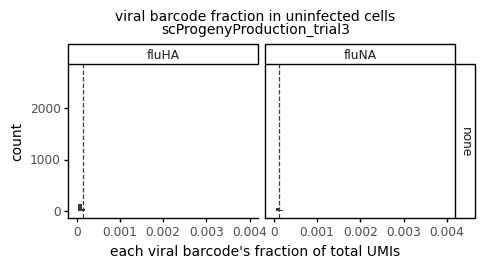

<ggplot: (8791840864672)>

In [27]:
limit_percentile = 0.99

uninfected_frac_limit = {}
for gene in barcoded_viral_genes:
    limit = (viral_bc_frac
             .query('(infecting_viral_tag == "none") '
                    f'and (gene == "{gene}")')
             ['frac_viral_bc_UMIs']
             .quantile(limit_percentile))
    uninfected_frac_limit[f'{gene}'] = limit
    print(f'The limit for a viral barcode on {gene} is {limit:.5f}.')

# Convert to DataFrame for plotting
uninfected_frac_limit = (pd.DataFrame.from_dict(uninfected_frac_limit,
                                                orient='index',
                                                columns=['limit'])
                         .reset_index()
                         .rename(columns={'index': 'gene'}))

fig = (p9.ggplot((viral_bc_frac
                  .query('infecting_viral_tag == "none"')),
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=50, fill="#3a3a3a") +
       p9.geom_vline(uninfected_frac_limit,
                     p9.aes(xintercept='limit'),
                     linetype='dashed',
                     color='#3A3B3C',
                     size=0.5) +
       p9.facet_grid('infecting_viral_tag~gene') +
       p9.ggtitle('viral barcode fraction in uninfected cells\n'
                  f'{expt}') +
       p9.labs(x='each viral barcode\'s fraction of total UMIs',) +
       p9.xlim((0,0.004)) +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Now calculate the expected number of viral barcode UMIs for each cell-gene using this upper bound limit. For every cell and gene, I will simply multiply the total number of UMIs by this limit value.

In [16]:
viral_bc_frac = pd.merge(left=viral_bc_frac,
                         right=uninfected_frac_limit,
                         on='gene',
                         how='outer',
                         validate='many_to_one')

viral_bc_frac['expected_limit_viral_bc_UMIs'] = (viral_bc_frac['total_UMIs'] *
                                                 viral_bc_frac['limit'])

viral_bc_frac

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,sum_UMIs_with_viral_bc_for_cell_and_gene,filtered,reason,limit,expected_limit_viral_bc_UMIs
0,AAACCCAGTAACAAGT,False,none,5699,0,5699,0.000000,fluHA,NaN,0,0.000000,0,False,[],0.000156,0.889618
1,AAACCCATCATTGCTT,False,none,10530,0,10530,0.000000,fluHA,NaN,0,0.000000,0,False,[],0.000156,1.643741
2,AAACGAAAGATGTTGA,False,none,13065,0,13065,0.000000,fluHA,NaN,0,0.000000,0,False,[],0.000156,2.039456
3,AAACGAAGTACTTCCC,True,wt,6629,3017,3612,0.455121,fluHA,NaN,0,0.000000,0,False,[],0.000156,1.034792
4,AAACGAAGTAGACGTG,True,wt,14162,517,13645,0.036506,fluHA,AAGTAAGCGACATGAG,18,0.001271,19,False,[],0.000156,2.210699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7706,TTTGATCTCCCGTTCA,False,none,7229,0,7229,0.000000,fluNA,NaN,0,0.000000,0,False,[],0.000126,0.913560
7707,TTTGATCTCGCATTGA,True,wt,19350,1226,18124,0.063359,fluNA,NaN,0,0.000000,0,False,[],0.000126,2.445343
7708,TTTGGAGAGTTGCCTA,False,none,7498,0,7498,0.000000,fluNA,NaN,0,0.000000,0,False,[],0.000126,0.947555
7709,TTTGGAGGTATCGTTG,True,wt,17202,423,16779,0.024590,fluNA,ACATCTTATTTACACG,6,0.000349,6,False,[],0.000126,2.173891


Next, I will do the statistical test for each barcode to see if it falls with in the poisson distribution with mu = `expected_limit_viral_bc_UMIs` value.

I will account for multiple hypothesis testing by adjust the probability using a false discovery rate specified in the config file.

In [17]:
viral_bc_frac['uninfected_P'] = (
    1 - scipy.stats.poisson.cdf(
        k=viral_bc_frac['viral_bc_UMIs'],
        mu=viral_bc_frac['expected_limit_viral_bc_UMIs']))

viral_bc_frac['uninfected_Q'] = (
    statsmodels.stats.multitest.fdrcorrection(
        pvals=viral_bc_frac['uninfected_P'],
        alpha=fdr,
        method='indep',
        is_sorted=False,
        )[1])

viral_bc_frac['reject_uninfected'] = (viral_bc_frac['uninfected_Q'] < fdr)

# Catalog filtered status
viral_bc_frac['filtered'] = (viral_bc_frac
                             .apply(
                                 (lambda row:
                                  check_filter(row['filtered'],
                                               not row['reject_uninfected'])),
                                    axis=1))
viral_bc_frac['reason'] = (viral_bc_frac
                           .apply(
                               (lambda row:
                                row['reason'].__add__(['not_above_background'])
                                if not row['reject_uninfected']
                                else row['reason']),
                                  axis=1))

display(viral_bc_frac)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,sum_UMIs_with_viral_bc_for_cell_and_gene,filtered,reason,limit,expected_limit_viral_bc_UMIs,uninfected_P,uninfected_Q,reject_uninfected
0,AAACCCAGTAACAAGT,False,none,5699,0,5699,0.000000,fluHA,NaN,0,0.000000,0,True,[not_above_background],0.000156,0.889618,5.891874e-01,9.400590e-01,False
1,AAACCCATCATTGCTT,False,none,10530,0,10530,0.000000,fluHA,NaN,0,0.000000,0,True,[not_above_background],0.000156,1.643741,8.067442e-01,9.400590e-01,False
2,AAACGAAAGATGTTGA,False,none,13065,0,13065,0.000000,fluHA,NaN,0,0.000000,0,True,[not_above_background],0.000156,2.039456,8.699005e-01,9.400590e-01,False
3,AAACGAAGTACTTCCC,True,wt,6629,3017,3612,0.455121,fluHA,NaN,0,0.000000,0,True,[not_above_background],0.000156,1.034792,6.446996e-01,9.400590e-01,False
4,AAACGAAGTAGACGTG,True,wt,14162,517,13645,0.036506,fluHA,AAGTAAGCGACATGAG,18,0.001271,19,False,[],0.000156,2.210699,3.559819e-12,9.336655e-11,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7706,TTTGATCTCCCGTTCA,False,none,7229,0,7229,0.000000,fluNA,NaN,0,0.000000,0,True,[not_above_background],0.000126,0.913560,5.989062e-01,9.400590e-01,False
7707,TTTGATCTCGCATTGA,True,wt,19350,1226,18124,0.063359,fluNA,NaN,0,0.000000,0,True,[not_above_background],0.000126,2.445343,9.133036e-01,9.400590e-01,False
7708,TTTGGAGAGTTGCCTA,False,none,7498,0,7498,0.000000,fluNA,NaN,0,0.000000,0,True,[not_above_background],0.000126,0.947555,6.123121e-01,9.400590e-01,False
7709,TTTGGAGGTATCGTTG,True,wt,17202,423,16779,0.024590,fluNA,ACATCTTATTTACACG,6,0.000349,6,True,[not_above_background],0.000126,2.173891,7.015968e-03,7.829252e-02,False


Plot P values and Q values for each barcode:

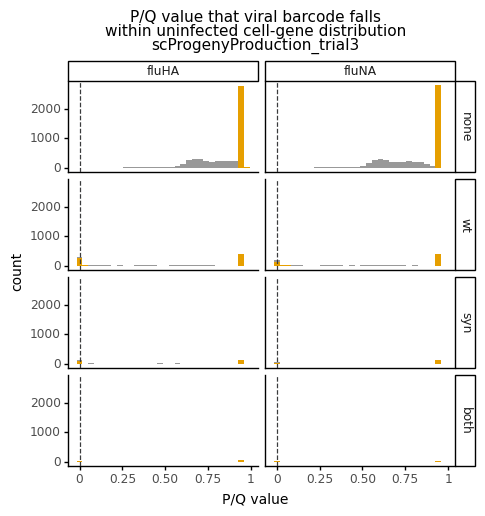

<ggplot: (8791849439570)>

In [18]:
fig = (p9.ggplot(viral_bc_frac) +
       p9.geom_histogram(p9.aes(x='uninfected_P'),
                         fill=CBPALETTE[0],
                         bins=30) +
       p9.geom_histogram(p9.aes(x='uninfected_Q'),
                         fill=CBPALETTE[1],
                         bins=30) +
       p9.geom_vline(xintercept=fdr,
                     linetype='dashed',
                     color='#3A3B3C',
                     size=0.5) +
       p9.facet_grid('infecting_viral_tag~gene') +
       p9.ggtitle('P/Q value that viral barcode falls\n'
                  'within uninfected cell-gene distribution\n'
                  f'{expt}') +
       p9.xlab('P/Q value') +
       p9.theme(figure_size=(5, 5),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot number of viral barcodes where null distribution was rejected:

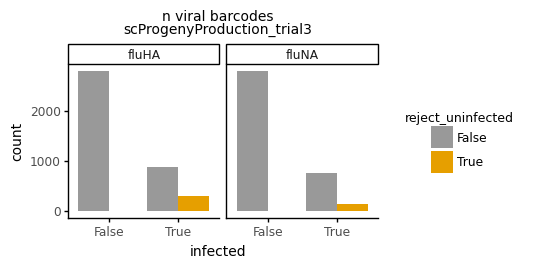

<ggplot: (8791849431763)>

In [19]:
fig = (p9.ggplot(viral_bc_frac,
                 p9.aes(x='infected',
                        fill='reject_uninfected')) +
       p9.geom_bar(stat='count', position='dodge') +
       p9.ggtitle('n viral barcodes\n'
                  f'{expt}') +
       p9.facet_grid('~gene') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

## Cells per viral barcode
Next, I want to remove viral barcodes that are found above background in multiple cells. This should be very unlikely in a low MOI infection.

Calculate the number of cells each viral barcode is found in:

In [20]:
n_cell_bc = (viral_bc_frac
             .groupby(['infecting_viral_tag',
                       'gene',
                       'viral_barcode',
                       'filtered'])
             ['cell_barcode']
             .nunique()
             .reset_index()
             .rename(columns={'cell_barcode': 'n_cell_bc'}))

n_cell_bc

viral_bc_frac = pd.merge(
    viral_bc_frac,
    n_cell_bc,
    on=['infecting_viral_tag',
        'gene',
        'viral_barcode',
        'filtered'],
    how='left')

viral_bc_frac

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,frac_viral_bc_UMIs,sum_UMIs_with_viral_bc_for_cell_and_gene,filtered,reason,limit,expected_limit_viral_bc_UMIs,uninfected_P,uninfected_Q,reject_uninfected,n_cell_bc
0,AAACCCAGTAACAAGT,False,none,5699,0,5699,0.000000,fluHA,NaN,0,0.000000,0,True,[not_above_background],0.000156,0.889618,5.891874e-01,9.400590e-01,False,NaN
1,AAACCCATCATTGCTT,False,none,10530,0,10530,0.000000,fluHA,NaN,0,0.000000,0,True,[not_above_background],0.000156,1.643741,8.067442e-01,9.400590e-01,False,NaN
2,AAACGAAAGATGTTGA,False,none,13065,0,13065,0.000000,fluHA,NaN,0,0.000000,0,True,[not_above_background],0.000156,2.039456,8.699005e-01,9.400590e-01,False,NaN
3,AAACGAAGTACTTCCC,True,wt,6629,3017,3612,0.455121,fluHA,NaN,0,0.000000,0,True,[not_above_background],0.000156,1.034792,6.446996e-01,9.400590e-01,False,NaN
4,AAACGAAGTAGACGTG,True,wt,14162,517,13645,0.036506,fluHA,AAGTAAGCGACATGAG,18,0.001271,19,False,[],0.000156,2.210699,3.559819e-12,9.336655e-11,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7706,TTTGATCTCCCGTTCA,False,none,7229,0,7229,0.000000,fluNA,NaN,0,0.000000,0,True,[not_above_background],0.000126,0.913560,5.989062e-01,9.400590e-01,False,NaN
7707,TTTGATCTCGCATTGA,True,wt,19350,1226,18124,0.063359,fluNA,NaN,0,0.000000,0,True,[not_above_background],0.000126,2.445343,9.133036e-01,9.400590e-01,False,NaN
7708,TTTGGAGAGTTGCCTA,False,none,7498,0,7498,0.000000,fluNA,NaN,0,0.000000,0,True,[not_above_background],0.000126,0.947555,6.123121e-01,9.400590e-01,False,NaN
7709,TTTGGAGGTATCGTTG,True,wt,17202,423,16779,0.024590,fluNA,ACATCTTATTTACACG,6,0.000349,6,True,[not_above_background],0.000126,2.173891,7.015968e-03,7.829252e-02,False,1.0


Plot distribution of cell barcode per viral barcode:

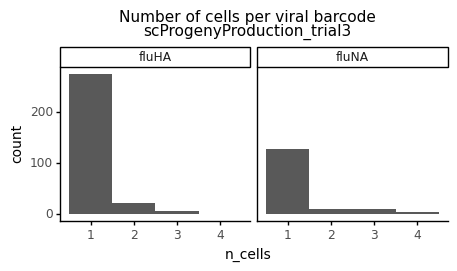

<ggplot: (8791840709133)>

In [30]:
fig = (p9.ggplot(viral_bc_frac
                 .query('reject_uninfected == True')) +
       p9.geom_histogram(p9.aes(x='n_cell_bc'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of cells per viral barcode\n'
                  f'{expt}') +
       p9.xlab('n_cells') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

### Remove viral barcodes that are found in more than 1 cell.
Now I will filter out viral barcodes that are found in more than 1 cells.

In [22]:
viral_bc_frac['too_many_cells'] = (viral_bc_frac['n_cell_bc'] > 1)

# Catalog filtered status
viral_bc_frac['filtered'] = (viral_bc_frac.apply((lambda row: check_filter(row['filtered'], row['too_many_cells'])), axis=1))

#viral_bc_frac['reason'] = (viral_bc_frac.apply((lambda row: row['reason'].__add__(['too_many_cells']) if row['too_many_cells'] else row['reason']), axis=1)

viral_bc_frac

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,gene,viral_barcode,viral_bc_UMIs,...,sum_UMIs_with_viral_bc_for_cell_and_gene,filtered,reason,limit,expected_limit_viral_bc_UMIs,uninfected_P,uninfected_Q,reject_uninfected,n_cell_bc,too_many_cells
0,AAACCCAGTAACAAGT,False,none,5699,0,5699,0.000000,fluHA,NaN,0,...,0,True,[not_above_background],0.000156,0.889618,5.891874e-01,9.400590e-01,False,NaN,False
1,AAACCCATCATTGCTT,False,none,10530,0,10530,0.000000,fluHA,NaN,0,...,0,True,[not_above_background],0.000156,1.643741,8.067442e-01,9.400590e-01,False,NaN,False
2,AAACGAAAGATGTTGA,False,none,13065,0,13065,0.000000,fluHA,NaN,0,...,0,True,[not_above_background],0.000156,2.039456,8.699005e-01,9.400590e-01,False,NaN,False
3,AAACGAAGTACTTCCC,True,wt,6629,3017,3612,0.455121,fluHA,NaN,0,...,0,True,[not_above_background],0.000156,1.034792,6.446996e-01,9.400590e-01,False,NaN,False
4,AAACGAAGTAGACGTG,True,wt,14162,517,13645,0.036506,fluHA,AAGTAAGCGACATGAG,18,...,19,False,[],0.000156,2.210699,3.559819e-12,9.336655e-11,True,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7706,TTTGATCTCCCGTTCA,False,none,7229,0,7229,0.000000,fluNA,NaN,0,...,0,True,[not_above_background],0.000126,0.913560,5.989062e-01,9.400590e-01,False,NaN,False
7707,TTTGATCTCGCATTGA,True,wt,19350,1226,18124,0.063359,fluNA,NaN,0,...,0,True,[not_above_background],0.000126,2.445343,9.133036e-01,9.400590e-01,False,NaN,False
7708,TTTGGAGAGTTGCCTA,False,none,7498,0,7498,0.000000,fluNA,NaN,0,...,0,True,[not_above_background],0.000126,0.947555,6.123121e-01,9.400590e-01,False,NaN,False
7709,TTTGGAGGTATCGTTG,True,wt,17202,423,16779,0.024590,fluNA,ACATCTTATTTACACG,6,...,6,True,[not_above_background],0.000126,2.173891,7.015968e-03,7.829252e-02,False,1.0,False


Plot number of viral barcodes that were found in too many cells:

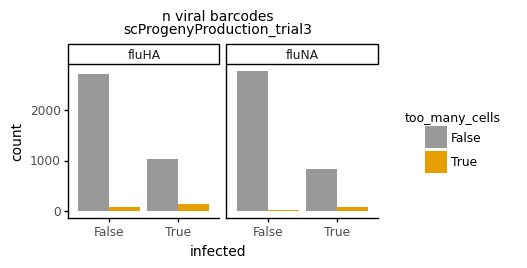

<ggplot: (8791840824775)>

In [23]:
fig = (p9.ggplot(viral_bc_frac,
                 p9.aes(x='infected',
                        fill='too_many_cells')) +
       p9.geom_bar(stat='count', position='dodge') +
       p9.ggtitle('n viral barcodes\n'
                  f'{expt}') +
       p9.facet_grid('~gene') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

## Calculate rate of missed and spurious barcodes
Want to know how many cells called as uninfected have >= 1 viral barcodes passing filter. 
Likewise, want to know how many cells called as infected have 0 viral barcodes passing filter.

I will check whether each cell-gene has any viral barcodes that pass filter. This call will be put in a column called `viral_bc_passing_filter_in_cell_gene`.

In [24]:
viral_bc_counts_passing_filter = (
    viral_bc_frac
    .groupby(['cell_barcode',
              'infected',
              'infecting_viral_tag',
              'gene'])
    ['filtered']
    .any()
    .dropna()
    .reset_index())

# Check that length of viral_bc_counts_passing_filter is 2X length of all cells
assert len(viral_bc_counts_passing_filter) == 2 * len(all_cells), \
    "Number of cells input does not match number of cell-gene " \
    "combinations generated"

viral_bc_counts_passing_filter['viral_bc_passing_filter_in_cell_gene'] = \
    ([not x
      for x
      in viral_bc_counts_passing_filter['filtered']])


viral_bc_counts_passing_filter

,cell_barcode,infected,infecting_viral_tag,gene,filtered,viral_bc_passing_filter_in_cell_gene
0,AAACCCAGTAACAAGT,False,none,fluHA,True,False
1,AAACCCAGTAACAAGT,False,none,fluNA,True,False
2,AAACCCATCATTGCTT,False,none,fluHA,True,False
3,AAACCCATCATTGCTT,False,none,fluNA,True,False
4,AAACGAAAGATGTTGA,False,none,fluHA,True,False
...,...,...,...,...,...,...
6725,TTTGGAGAGTTGCCTA,False,none,fluNA,True,False
6726,TTTGGAGGTATCGTTG,True,wt,fluHA,True,False
6727,TTTGGAGGTATCGTTG,True,wt,fluNA,True,False
6728,TTTGTTGAGTGCAGCA,False,none,fluHA,True,False


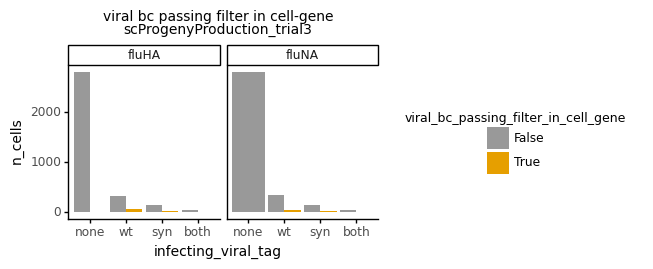

<ggplot: (8791840645753)>

In [25]:
output_fig = (p9.ggplot(
        viral_bc_counts_passing_filter,
        p9.aes(x='infecting_viral_tag',
               fill='viral_bc_passing_filter_in_cell_gene')) +
              p9.geom_bar(stat='count', position='dodge') +
              p9.ggtitle('viral bc passing filter in cell-gene\n'
                         f'{expt}') +
              p9.ylab('n_cells') +
              p9.facet_grid('~gene') +
              p9.theme(figure_size=(4, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(output_fig)

In [26]:
print(f"Saving plots to {plot}")
p9.ggsave(plot=output_fig, filename=plot, verbose=False)

print(f"Saving filtered barcodes to {viral_bc_by_cell_filtered_csv}")

# Export all barcodes, and annotate whether uninfected null hypothesis
# is rejected. Could imagine filtering on other criteria in future.
viral_bc_frac.to_csv(viral_bc_by_cell_filtered_csv,
                     columns=['cell_barcode',
                              'gene',
                              'viral_barcode',
                              'frac_viral_bc_UMIs',
                              'reject_uninfected',
                              'too_many_cells'],
                     index=False)

Saving plots to results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_by_cell_filtered.pdf
Saving filtered barcodes to results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_by_cell_filtered.csv.gz
